### For given aoi, prepare TCI and NDVI sentinel latest images 

In [135]:
AOI = 'POLYGON ((35.4638671875000000 50.4365160169863316, 34.6618652343750000 50.0289165635219035, 34.7827148437500000 48.9549736980886792, 36.3757324218749929 48.3781454697624440, 37.4194335937500000 48.7851519980431547, 38.3038330078125000 49.4431287580300491, 37.9193115234374929 50.4120182466821731, 36.6009521484375000 50.5553249825196716, 35.4638671875000000 50.4365160169863316))' 

START_DATE = "2019-06-01"
END_DATE = "2019-06-10"

In [136]:
import os
import geopandas as gp
import numpy as np
import rasterio
import re
import tempfile
import pyproj
import uuid

import rasterio.mask
from rasterio import Affine
from rasterio.plot import reshape_as_raster
from rasterio.merge import merge
from rasterio.warp import calculate_default_transform, reproject, Resampling

from shapely import wkt
from shapely.geometry import Polygon, box
from shapely.ops import transform


from pathlib import Path
from datetime import datetime, timedelta
from sentinel2download.downloader import Sentinel2Downloader
from sentinel2download.overlap import Sentinel2Overlap

#### 1. Transform AOI and get bound_box

In [137]:
aoi = gp.GeoDataFrame(geometry=[wkt.loads(AOI)], crs="epsg:4326")    
bbox = box(*aoi.total_bounds)

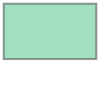

In [138]:
bbox

In [139]:
aoi

,geometry
0,"POLYGON ((35.46387 50.43652, 34.66187 50.02892..."


#### Сreate base path, usually env=jovyan

In [140]:
BASE = f"/home/{os.getenv('NB_USER')}/work"
BASE

'/home/jovyan/work'

In [141]:
sentinel_grid = gp.read_file("sentinel2grid.geojson")

#### 2. Overlap AOI with sentinel2grid 

In [142]:
def epsg_code(longitude, latitude):
        """
        Generates EPSG code from lon, lat
        :param longitude: float
        :param latitude: float
        :return: int, EPSG code
        """

        def _zone_number(lat, lon):
            if 56 <= lat < 64 and 3 <= lon < 12:
                return 32
            if 72 <= lat <= 84 and lon >= 0:
                if lon < 9:
                    return 31
                elif lon < 21:
                    return 33
                elif lon < 33:
                    return 35
                elif lon < 42:
                    return 37

            return int((lon + 180) / 6) + 1

        zone = _zone_number(latitude, longitude)

        if latitude > 0:
            return 32600 + zone
        else:
            return 32700 + zone

In [143]:
def _intersect(aoi, grid):
    # Get the indices of the tiles that are likely to be inside the bounding box of the given Polygon
    geometry = aoi.geometry[0]

    tiles_indexes = list(grid.sindex.intersection(geometry.bounds))
    grid = grid.loc[tiles_indexes]

    # Make the precise tiles in Polygon query
    grid = grid.loc[grid.intersects(geometry)]

    # intersection area
    epsg = epsg_code(geometry.centroid.x, geometry.centroid.y)

    # to UTM projection in meters
    aoi.to_crs(epsg=epsg, inplace=True)
    grid.to_crs(epsg=epsg, inplace=True)

    return grid, epsg

In [144]:
def get_intersected_tiles(aoi, grid):
    
    grid, epsg = _intersect(aoi, sentinel_grid)
    
    
    grid.set_index("Name", drop=False, inplace=True)    
    intersected_grid = {"tile": [], "geometry": []}

    rest_aoi = aoi.copy()
    while rest_aoi.area.sum() > 0:
        intersection = gp.overlay(rest_aoi, grid, how="intersection")
        argmax = intersection.area.argmax()

        tile = intersection.loc[argmax, "Name"]
        intersected_geometry = intersection.loc[argmax, "geometry"]
        
        intersected_grid["tile"].append(tile)
        intersected_grid["geometry"].append(intersected_geometry)
        
        biggest_intersection = grid.loc[[tile]]
        rest_aoi = gp.overlay(rest_aoi, biggest_intersection, how="difference")
        grid = grid.loc[intersection["Name"]]

    return gp.GeoDataFrame(intersected_grid, crs=epsg)

In [145]:
overlap_tiles = get_intersected_tiles(aoi.copy(), grid.copy())
overlap_tiles

,tile,geometry
0,36UYA,"POLYGON Z ((274247.076 5596259.864 0.000, 2979..."
1,36UYV,MULTIPOLYGON Z (((265832.512 5491603.656 0.000...
2,36UXV,MULTIPOLYGON Z (((263553.717 5391432.775 0.000...
3,36UXA,"POLYGON Z ((248907.683 5593143.189 0.000, 2742..."
4,37UDR,"POLYGON Z ((399960.000 5589525.403 0.000, 4232..."
5,37UCQ,"POLYGON Z ((375629.031 5487769.228 0.000, 3766..."
6,37UCR,"POLYGON Z ((376614.166 5500020.000 0.000, 3840..."
7,37UDQ,"POLYGON Z ((409800.000 5490240.000 0.000, 4462..."
8,36UYU,"POLYGON Z ((257921.374 5391876.403 0.000, 2635..."
9,36UYB,MULTIPOLYGON Z (((304980.586 5600040.000 0.000...


In [146]:
overlap_tiles.crs

<Projected CRS: EPSG:32637>
Name: WGS 84 / UTM zone 37N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - N hemisphere - 36°E to 42°E - by country
- bounds: (36.0, 0.0, 42.0, 84.0)
Coordinate Operation:
- name: UTM zone 37N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

#### 3. Load images

In [147]:
API_KEY = os.path.join(BASE, ".secret/sentinel2_google_api_key.json")
LOAD_DIR = os.path.join(BASE, "satellite_imagery")

PRODUCT_TYPE = 'L2A'
BANDS = {'TCI', 'B04', 'B08', }
CONSTRAINTS = {'NODATA_PIXEL_PERCENTAGE': 10.0, 'CLOUDY_PIXEL_PERCENTAGE': 5.0, }

LAYERS = ['TCI', 'NDVI', ]

In [148]:
START_DATE

'2019-06-01'

In [149]:
END_DATE

'2019-06-10'

In [150]:
def shift_dates(start_date, end_date, delta=5, format='%Y-%m-%d'):
    start = datetime.strptime(start_date, format)
    end = datetime.strptime(end_date, format)
    
    start = start - timedelta(days=delta)
    end = end + timedelta(days=delta)
    difference = (end-start).days
    
    return datetime.strftime(start, format), datetime.strftime(end, format), difference

In [151]:
def shift_date(date, delta=5, format='%Y-%m-%d'):
    date = datetime.strptime(date, format)
    date = date - timedelta(days=delta)    
    return datetime.strftime(date, format)

#### 3.1 Define max difference shift in dates for loading images as default factor=20% from input datarange

In [152]:
start_difference = (datetime.strptime(END_DATE, '%Y-%m-%d') - datetime.strptime(START_DATE,'%Y-%m-%d')).days
start_difference

9

In [153]:
FACTOR = 0.2
MAX_SHIFT = round(start_difference * FACTOR)
MAX_SHIFT

2

In [154]:
def load_images(tiles, start_date, end_date):
    loader = Sentinel2Downloader(API_KEY)
    
    loadings = dict()
        
    for tile in tiles:
        start = start_date
        end = end_date
        
        print(f"Loading images for tile: {tile}...")
        
        for _ in range(0, 2):
            loaded = loader.download(PRODUCT_TYPE,
                                [tile],
                                start_date=start,
                                end_date=end,
                                output_dir=LOAD_DIR,                       
                                bands=BANDS,
                                constraints=CONSTRAINTS)
        
            if not loaded:
                print(f"For tile: {tile} and dates {start} {end} proper images not found!")
                end = start_date
                start = shift_date(start_date, delta=MAX_SHIFT) 
                print(f"For tile: {tile} shift dates to {start} {end} proper images not found!")
            else:
                print(f"Loading images for tile {tile} finished")
                loadings[tile] = loaded
                break
    
    # tile_folders = dict()
    # for tile, tile_paths in loadings.items():
    #    tile_folders[tile] = {str(Path(tile_path[0]).parent) for tile_path in tile_paths}
    return loadings

In [155]:
overlap_tiles.tile.values[0]

'36UYA'

In [156]:
tile = [overlap_tiles.tile.values[0]]

In [157]:
loadings = load_images(tile, START_DATE, END_DATE)

Loading images for tile: 36UYA...
Loading images for tile 36UYA finished


In [158]:
loadings

{'36UYA': [('/home/jovyan/work/satellite_imagery/S2A_MSIL2A_20190606T083601_N0212_R064_T36UYA_20190606T112641/MTD_TL.xml',
   'L2/tiles/36/U/YA/S2A_MSIL2A_20190606T083601_N0212_R064_T36UYA_20190606T112641.SAFE/GRANULE/L2A_T36UYA_A020653_20190606T083602/MTD_TL.xml'),
  ('/home/jovyan/work/satellite_imagery/S2A_MSIL2A_20190606T083601_N0212_R064_T36UYA_20190606T112641/T36UYA_20190606T083601_B04_10m.jp2',
   'L2/tiles/36/U/YA/S2A_MSIL2A_20190606T083601_N0212_R064_T36UYA_20190606T112641.SAFE/GRANULE/L2A_T36UYA_A020653_20190606T083602/IMG_DATA/R10m/T36UYA_20190606T083601_B04_10m.jp2'),
  ('/home/jovyan/work/satellite_imagery/S2A_MSIL2A_20190606T083601_N0212_R064_T36UYA_20190606T112641/T36UYA_20190606T083601_TCI_10m.jp2',
   'L2/tiles/36/U/YA/S2A_MSIL2A_20190606T083601_N0212_R064_T36UYA_20190606T112641.SAFE/GRANULE/L2A_T36UYA_A020653_20190606T083602/IMG_DATA/R10m/T36UYA_20190606T083601_TCI_10m.jp2'),
  ('/home/jovyan/work/satellite_imagery/S2A_MSIL2A_20190606T083601_N0212_R064_T36UYA_20190606

#### 3.2 Filter loadings for every tile, get last image in daterange

In [ ]:
def filter_by_date(loadings):
    def _find_last_date(folders):        
        dates = list()
        for folder in folders:        
            search = re.search(r"_(\d+)T\d+_", str(folder))
            date = search.group(1)
            date = datetime.strptime(date, '%Y%m%d')
            dates.append(date)    
        last_date = max(dates)
        last_date = datetime.strftime(last_date, '%Y%m%d')
        return last_date
    
    filtered = dict()
    for tile, items in loadings.items():
        try:
            last_date = _find_last_date(items)
            for file, _ in items:
                if "TCI_10m.jp2" in file and last_date in file:
                    filtered[tile] = file
        except Exception as ex:
            print(f"Error for {tile}: {str(ex)}")
    return filtered

In [ ]:
if not filtered:
    raise ValueError("Images not loaded. Change date or constraints")

In [ ]:
for path in paths:
            if 'B04' in path:
                bands_paths['RED'] = path
            if 'B08' in path:
                bands_paths['NIR'] = path
            if 'TCI' in path:
                bands_paths['TCI'] = path

In [ ]:
loadings = load_images(aoi_path, API_KEY, LOAD_DIR)
filtered = filter_loadings(loadings)

In [ ]:
RESULTS_DIR = os.path.join(BASE, "results/example/tci_ndvi")

NOTEBOOK_DIR = os.path.join(BASE, "notebooks/example/tci_ndvi")
COLORMAP_BRBG = os.path.join(NOTEBOOK_DIR, "brbg.npy") 

In [ ]:
COLORS = prepare_colors(COLORMAP_BRBG)

In [ ]:
def prepare_colors(colors):
    colors = np.load(COLORMAP_BRBG)
    # delete last channel, we use rgb
    colors = np.delete(colors, 3, axis=1)
    # colormap colors values in range [0-255], but in our case 0 - no data, -> have to color as [0, 0, 0] 
    colors[colors == 0] = 1
    colors[0] = [0, 0, 0]
    return colors

In [ ]:
def crop(input_path, output_path, polygon, name, date):
    with rasterio.open(input_path) as src:
        out_image, out_transform = rasterio.mask.mask(src, [polygon], crop=True)
        # print(out_transform)
        out_meta = src.meta
        
        out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform,
                 "nodata": 0,
                        })

    with rasterio.open(output_path, "w", **out_meta) as dest:
        dest.update_tags(name=name, start_date=date, end_date=date)
        dest.write(out_image)

In [ ]:
def convert(input_path, output_path, driver='GTiff'):
    with rasterio.open(input_path) as src:
        raster = src.read()
        crs = str(src.crs)
        
        # print("CONVERTED CRS")
        # print(crs)
                
        kwargs = src.meta.copy()
        kwargs.update({'driver': driver})
        
        
        with rasterio.open(output_path, 'w', **kwargs) as dst:
            dst.write(raster)
        return crs

In [ ]:
def to_crs(poly, target, current='EPSG:4326'):
    # print(f"TARGET CRS: {target}")
    project = pyproj.Transformer.from_crs(pyproj.CRS(current), pyproj.CRS(target), always_xy=True).transform
    transformed_poly = transform(project, poly)
    return transformed_poly 

In [ ]:
def generate_dates(delta=20, format='%Y-%m-%d'):
    now = datetime.now()
    end_date = datetime(now.year, now.month, now.day)

    while True:
        start_date = end_date - timedelta(days=delta)
        yield datetime.strftime(start_date, format), datetime.strftime(end_date, format)
        end_date = start_date

In [ ]:
def load_images(aoi_path, api_key, output_dir):
    
    overlap = Sentinel2Overlap(aoi_path)
    tiles = overlap.overlap()
    print(f"Overlap tiles: {tiles}")
    
    loader = Sentinel2Downloader(api_key)
    loadings = dict()
    for tile in tiles:
        print(f"Loading images for tile: {tile}...")
        for start_date, end_date in generate_dates():
            print(f"Dates from {start_date} to {end_date}")
            loaded = loader.download('L2A',
                                     [tile],
                                     start_date=start_date,
                                     end_date=end_date,
                                     output_dir=output_dir,                       
                                     bands=BANDS,
                                     constraints=CONSTRAINTS)

            if loaded:
                print(f"Loading images for tile {tile} finished")
                loadings[tile] = loaded
                break
            else:
                print("No matching images")
    return loadings

In [ ]:
def last_image_paths(loaded):
    date_pattern = r"_(\d+)T\d+_"
    dates = list()
    for path, _ in loaded:
        if path.endswith('.jp2'):
            search = re.search(date_pattern, path)
            date = search.group(1)
            date = datetime.strptime(date, '%Y%m%d')
            dates.append(date)
    
    last_date = max(dates)
    last_date = datetime.strftime(last_date, '%Y%m%d')
    paths = list()
    for path, _ in loaded:
        if path.endswith('.jp2') and last_date in path:
            paths.append(path)
    return paths, last_date

In [ ]:
def filter_loadings(loadings):
    filtered = dict()
    for tile, image_paths in loadings.items():        
        paths, date = last_image_paths(image_paths)
        bands_paths = dict()
        for path in paths:
            if 'B04' in path:
                bands_paths['RED'] = path
            if 'B08' in path:
                bands_paths['NIR'] = path
            if 'TCI' in path:
                bands_paths['TCI'] = path
        filtered[tile] = dict(paths=bands_paths, date=date)
    return filtered

In [ ]:
def _save_original_ndvi(ndvi, src, path, nodata=-1000):
    # mask nan values
    nan_mask = np.isnan(ndvi)
    ndvi[nan_mask] = nodata
    
    # Set spatial characteristics of the output object
    kwargs = src.meta.copy()    
    kwargs.update(
        dtype=rasterio.float32,
        driver='GTiff',
        nodata=nodata,
        count = 1)
    
    # print(f"Metadata of NDVI: {kwargs}")

    # Create the file
    with rasterio.open(path, 'w', **kwargs) as dst:
         dst.write(ndvi.astype(rasterio.float32), 1)

In [ ]:
def scale(ndvi, a=1, b=255, nodata=0.0):
    # ndvi is in range [-1; 1], nodata is setted to 0.0 value. Be careful with comprassions!
    min = -1 # np.nanmin(ndvi)
    max = 1 # np.nanmax(ndvi)
    scaled = (b - a) * (ndvi - min) / (max - min) + a
    scaled = np.around(scaled)
    scaled[np.isnan(scaled) == True] = nodata
    scaled = scaled.astype(np.uint8)
    return scaled

In [ ]:
def color_ndvi(scaled, colors):
    colored = np.reshape(colors[scaled.flatten()], tuple((*scaled.shape, 3)))
    colored = reshape_as_raster(colored)
    return colored

In [ ]:
def NDVI(nir_path, red_path, save_path):
    print("Calculating NDVI...")
    # Allow division by zero
    np.seterr(divide='ignore', invalid='ignore')
    
    with rasterio.open(nir_path) as src:
        nir = src.read(1).astype(rasterio.float32)
        crs = str(src.crs)
    with rasterio.open(red_path) as src:
        red = src.read(1).astype(rasterio.float32)

    # Calculate NDVI
    ndvi = ((nir - red) / (nir + red)) 
    
    scaled = scale(ndvi)
    colored = color_ndvi(scaled, COLORS) 
    
    
    # Set spatial characteristics of the output object
    kwargs = src.meta.copy()    
    kwargs.update(
        dtype=rasterio.uint8,
        driver='GTiff',
        nodata=0,
        count=3, )
    
    # print(f"Metadata of NDVI: {kwargs}")

    # Create the file
    with rasterio.open(save_path, 'w', **kwargs) as dst:
         dst.write(colored)
    print("NDVI calculation finished")
    return crs

In [ ]:
def get_path(path, layer, base, name, suffix=None):
    if layer == 'NDVI':
        stem = Path(path).stem
        stem = re.sub(r"_B\d{2}", '_NDVI', stem)
    else:
        stem = Path(path).stem
    path = os.path.join(base, f"{name}_{stem}.tif")
    if suffix:
         path += suffix
    os.makedirs(os.path.dirname(path), exist_ok=True)
    return path

In [ ]:
def reproject_image(input_path, dst_crs='EPSG:3857'):
    with rasterio.open(input_path) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
            })
        output_path = f"{input_path[:-4]}_{dst_crs.replace(':', '_').lower()}.tif" 
        with rasterio.open(output_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)
    return output_path 

In [ ]:
def get_start_end_date(filtered):
    dates = list()
    for tile, properties in filtered.items():
        date = properties['date']
        date = datetime.strptime(date, '%Y%m%d')
        dates.append(date)
    
    start_date = max(dates)
    end_date = min(dates)
    return datetime.strftime(start_date, '%Y-%m-%d'), datetime.strftime(end_date, '%Y-%m-%d')

In [ ]:
def generate_mosaic(layer, files_to_mosaic, name, start_date, end_date, results_dir):
    src_files_to_mosaic = list()
    for fp in files_to_mosaic:
        src = rasterio.open(fp)
        src_files_to_mosaic.append(src)
    
    # crs of first input will be used
    mosaic, out_trans = merge(src_files_to_mosaic)
    # print(src)
    out_meta = src.meta.copy()
    # print(out_meta)
    # print(out_meta['crs'])

    # Update the metadata
    out_meta.update({"driver": "GTiff",
                     "height": mosaic.shape[1],
                     "width": mosaic.shape[2],
                     "transform": out_trans,
                     })
    
    out_fp = os.path.join(results_dir, f"{name}_{layer}_{start_date}_{end_date}_mosaic.tif.temp") 
    # print(out_fp)
    os.makedirs(os.path.dirname(out_fp), exist_ok=True)
    with rasterio.open(out_fp, "w", **out_meta) as dest:
        dest.update_tags(name=name, start_date=start_date, end_date=end_date)
        dest.write(mosaic)
    os.rename(out_fp, out_fp[:-5])

In [ ]:
def calculate(layer, temp_dir, bbox, name, properties):
    """
    Preparing true color Sentinel2 and NDVI images for given AOI
    """
    print("Calculating TCI and NDVI for given AOI...")
    
    image_paths = properties['paths']
    date = properties['date']
  
    if layer == 'TCI':       
        # convert .jp2 image to .tif
        path = image_paths['TCI']
        temp_path = get_path(path, layer, temp_dir, name)    
        print(f"Save {layer} image path: {temp_path}")
            
        target_crs = convert(path , temp_path) 
            
    if layer == 'NDVI':
        path = image_paths['RED']
        temp_path = get_path(path, layer, temp_dir, name)    
        print(f"Save {layer} image path: {temp_path}")
            
        # calculate NDVI
        target_crs = NDVI(image_paths['NIR'], image_paths['RED'], temp_path)
    
    # print("TARGET CRS")
    # print(target_crs)
    bound_box = to_crs(bbox, target_crs)   

    
    temp_output_path = get_path(path, layer, temp_dir, name, suffix=".temp")
    print(f"Temporary {layer} output path: {temp_output_path}")
    
    # crop .tif image by aoi
    crop(temp_path, temp_output_path, bound_box, name, date)   
    
    
    output_path = temp_output_path[:-5]
    print(f"Rename temp file: {temp_output_path} to {output_path}")
    os.rename(temp_output_path, output_path)
    
    
    # for warping in mosaic, reproject to same crs, set to 'EPSG:3857' 
    output_path = reproject_image(output_path)  
    
    print(output_path)
        
    
    return output_path

### Execution part

In [ ]:
BASE = f"/home/{os.getenv('NB_USER')}/work"

In [ ]:
aoi_path = os.getenv("AOI", default=os.path.join(BASE, "notebooks/example/tci_ndvi/Pechenihy.geojson")) 
if not aoi_path:
    raise RuntimeError("Add AOI env var for calculations")
    
aoi_path

In [ ]:
API_KEY = os.path.join(BASE, ".secret/sentinel2_google_api_key.json")
LOAD_DIR = os.path.join(BASE, "satellite_imagery")
RESULTS_DIR = os.path.join(BASE, "results/example/tci_ndvi")

SIP_DIR = os.path.join(BASE, "notebooks/example/tci_ndvi")
COLORMAP_BRBG = os.path.join(SIP_DIR, "brbg.npy") 
COLORS = prepare_colors(COLORMAP_BRBG)


BANDS = {'TCI', 'B04', 'B08', }
CONSTRAINTS = {'NODATA_PIXEL_PERCENTAGE': 10.0, 'CLOUDY_PIXEL_PERCENTAGE': 5.0, }

LAYERS = ['TCI', 'NDVI', ]

#### Get bound box

In [ ]:
aoi = gp.read_file(aoi_path)    
bbox = box(*aoi.total_bounds)

NAME = Path(aoi_path).stem

#### Loading images

In [ ]:
loadings = load_images(aoi_path, API_KEY, LOAD_DIR)
filtered = filter_loadings(loadings)

In [ ]:
filtered

### TCI, NDVI and mosaic calculation

In [ ]:
SIP_DIR

In [ ]:
RESULTS_DIR

In [ ]:
# if true, mosaic will be created, else every file will be saved (for debugging)
ONLY_MOSAIC = True

In [ ]:
with tempfile.TemporaryDirectory(dir=SIP_DIR) as tmpdirname:
    layer_paths = dict()
    if not ONLY_MOSAIC:
        tmpdirname = os.path.join(SIP_DIR, "results")
        
    print(f"Сreated temporary directory for calculations: {tmpdirname}")   
    for layer in LAYERS:
        print(f"\nCalculating {layer}:\n")
        paths = list()
        for tile, properties in filtered.items():
            print(f"\nExecution for tile {tile}")
            
            save_path = calculate(layer, tmpdirname, bbox, NAME, properties)
            
            paths.append(save_path)
            
        layer_paths[layer] = paths
        print(f"Execution for tile {tile} finished")
    
    # print(layer_paths)
    
    print("\nCREATING MOSAIC\n")
    start_date, end_date = get_start_end_date(filtered)
    print(f"Date range for mosaic from {start_date} till {end_date}")

    for layer, files_to_mosaic in layer_paths.items():
        print(f"\nGenerating mosaic for {layer}")
        generate_mosaic(layer, files_to_mosaic, NAME, start_date, end_date, RESULTS_DIR)
        print("\nGenerating mosaic finished")